In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashwiniyer176/toxic-tweets-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toxic-tweets-dataset


In [5]:
import os
import pandas as pd

df = pd.read_csv(os.path.join(path, "FinalBalancedDataset.csv"))

In [6]:
file_path = os.path.join(path, "FinalBalancedDataset.csv")

In [5]:
df = pd.read_csv(file_path, index_col="Unnamed: 0") # remove index column

In [6]:
df.head()

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
df["Toxicity"].value_counts() # data matches binary classification as described

,count
Toxicity,
0,32592
1,24153


In [8]:
#binary text classification 0=not toxic, 1=toxic

df.shape

(56745, 2)

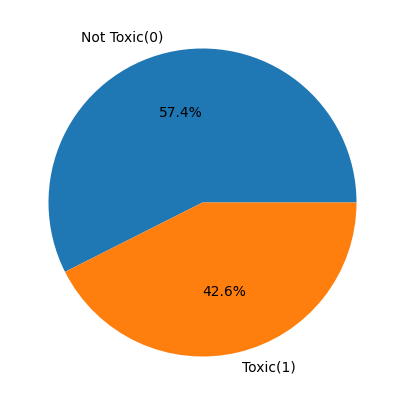

In [9]:
import matplotlib.pyplot as plt

pie_chart_df = df["Toxicity"].value_counts().sort_index()

plt.figure(figsize=(5,5))

plt.pie(pie_chart_df, labels=["Not Toxic(0)", "Toxic(1)"], autopct='%1.1f%%')
plt.show()


In [10]:
print(f'imbalance of classes: {57.4-42.6}%')

imbalance of classes: 14.799999999999997%


In [11]:
from transformers import BertTokenizer

In [58]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [59]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [60]:
X = df['tweet'].values
y= df["Toxicity"].values

In [61]:
sequences = [sequence for sequence in X]

model_inputs = tokenizer(sequences, padding=True, return_tensors='tf')

In [62]:
model_inputs

{'input_ids': <tf.Tensor: shape=(56745, 481), dtype=int32, numpy=
array([[  101,  1030,  5310, ...,     0,     0,     0],
       [  101,  1030,  5310, ...,     0,     0,     0],
       [  101, 12170, 14945, ...,     0,     0,     0],
       ...,
       [  101,  2402, 10131, ...,     0,     0,     0],
       [  101,  2017,  2226, ...,     0,     0,     0],
       [  101,  1066,  1066, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(56745, 481), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(56745, 481), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [15]:
import tensorflow as tf

In [63]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"],y))

In [64]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [65]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Layer

# IMPROVEMENT: If model starts paying attension on one part of the sentence more
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs: [batch, time_step, hidden_size]
        score = tf.nn.tanh(tf.keras.layers.Dense(1)(inputs))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

model = Sequential(name="toxic-text-classifier")

model.add(Embedding(input_dim=tokenizer.vocab_size, output_dim=32, input_length=100))
model.add(Bidirectional(LSTM(32, activation="tanh")))

model.add(Attention()) # Custom attention layer

model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

In [67]:
model.build(input_shape=(None, 100))

In [69]:
model.summary()

Model: "toxic-text-classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 32)        │       976,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,713 (4.07 MB)

 Trainable params: 1,067,713 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', "precision", "recall"])

In [71]:
with tf.device("/device:GPU:0"):
  history = model.fit(train, epochs=1, batch_size=16, validation_data=val)


2482/2482 ━━━━━━━━━━━━━━━━━━━━ 932s 372ms/step - accuracy: 0.8799 - loss: 0.2728 - val_accuracy: 0.9535 - val_loss: 0.1257
